In [1]:
import numpy as np
import pandas as pd

log_pr_file = './log_price.df'
volu_usd_file = './volume_usd.df'

log_pr = pd.read_pickle(log_pr_file)
volu = pd.read_pickle(volu_usd_file)

daylen = 12

def interpolate(log_pr, volu, window=30):
    log_pr.columns = ['log_pr_%d'%i for i in range(10)]
    volu.columns = ['volu_%d'%i for i in range(10)]

    open_ = log_pr[::window].reindex(log_pr.index).ffill()
    open_.columns = ['open_%d'%i for i in range(10)]
    close_ = log_pr[window-1::window].reindex(log_pr.index).bfill()
    close_.columns = ['close_%d'%i for i in range(10)]
    high_ = log_pr.groupby(np.arange(len(log_pr))//window) \
            .max().set_index(np.arange(0, len(log_pr), window)) \
            .reindex(np.arange(len(log_pr))).ffill().set_index(log_pr.index)
    high_.columns = ['high_%d'%i for i in range(10)]
    low_ = log_pr.groupby(np.arange(len(log_pr))//window) \
            .min().set_index(np.arange(0, len(log_pr), window)) \
            .reindex(np.arange(len(log_pr))).ffill().set_index(log_pr.index)
    low_.columns = ['low_%d'%i for i in range(10)]
    return pd.concat([log_pr, volu, open_, close_, high_, low_], axis=1)

# data = interpolate(log_pr, volu, daylen)

In [2]:
# Simple Moving Average
def SMA(x, window):
    return x.rolling(window).mean()

# exponential moving average
def EMA(x, window):
    return x.ewm(com=1/window, adjust=True, min_periods=window).mean()

# Average True Range
def ATR(low, high, close, window, daylen, index):
    # low = x[['low_%d'%i for i in range(10)]].iloc[::daylen].copy()
    # high = x[['high_%d'%i for i in range(10)]].iloc[::daylen].copy()
    # close = x[['close_%d'%i for i in range(10)]].iloc[::daylen].copy()
    
    high_low = high.values - low.values
    high_close = np.abs(high.values - close.shift().values)
    low_close = np.abs(low.values - close.shift().values)

    ranges = np.stack([high_low, high_close, low_close], axis=0)
    true_range = np.max(ranges, axis=0)
    true_range = pd.DataFrame(true_range, 
                              index=close.index, columns=['atr_%d'%i for i in range(10)])
    atr = EMA(true_range, window)
    atr = atr.reindex(index).ffill()
    return atr

# TODO
# Average Directional Movement Index
def ADX(low, high, close, window, daylen, index):
    # low = x[['low_%d'%i for i in range(10)]].iloc[::daylen].copy()
    # high = x[['high_%d'%i for i in range(10)]].iloc[::daylen].copy()
    # close = x[['close_%d'%i for i in range(10)]].iloc[::daylen].copy()
    
    plus_dm = high.diff()
    minus_dm = low.diff()
    plus_dm[plus_dm < 0] = 0
    minus_dm[minus_dm > 0] = 0
    
    atr = ATR(low, high, close, window, daylen, index).iloc[::daylen]
#     print(atr)
    
    plus_di = (100 * EMA(plus_dm, window) / atr.values).values
    minus_di = abs(100 * EMA(minus_dm, window) / atr.values).values
    
    adx = (abs(plus_di - minus_di) / abs(plus_di + minus_di + 1e-4)) * 100
    adx = pd.DataFrame(adx, index=close.index, columns=['adx_%d'%i for i in range(10)])
    adx = ((adx.shift() * (window - 1)) + adx) / window
    adx_smooth = EMA(adx, window)
    adx_smooth = adx_smooth.reindex(index).ffill()
    return adx_smooth

# Commodity Channel Index
def CCI(low, high, close, window, index):
    # low = x[['low_%d'%i for i in range(10)]].iloc[::daylen].copy()
    # high = x[['high_%d'%i for i in range(10)]].iloc[::daylen].copy()
    # close = x[['close_%d'%i for i in range(10)]].iloc[::daylen].copy()
    
    m = (high.values + low.values + close)/3
#     return m
    sma = SMA(m, window)
#     return sma
    mad_ = m.rolling(window).apply(lambda x: pd.Series(x).mad())
    cci = pd.DataFrame((m.values - sma.values)/(0.015*mad_.values), 
                       index=close.index, columns=['cci_%d'%i for i in range(10)])
    cci = cci.reindex(index).ffill()
    return cci

# Price Rate of Change
def ROC(close, window, daylen, index):
    # close = x[['close_%d'%i for i in range(10)]].iloc[::daylen].copy()
    roc = close.pct_change(window)
    roc.columns = ['roc_%d'%i for i in range(10)]
    roc = roc.reindex(index).ffill()
    return roc

# Relative Strength Index
def RSI(close, window, daylen, index, ema=True):
    # close = x[['close_%d'%i for i in range(10)]].iloc[::daylen].copy()
    
    # Make two series: one for lower closes and one for higher closes
    up = close.diff().clip(lower=0)
    down = -1 * close.diff().clip(upper=0)
    
    if ema == True:
        # Use exponential moving average
        ma_up = EMA(up, window)
        ma_down = EMA(down, window)
    else:
        # Use simple moving average
        ma_up = SMA(up, window)
        ma_down = SMA(down, window)
        
    rsi = ma_up.values / (ma_down.values + 1e-4)
    rsi = 100 - (100/(1 + rsi))
    rsi = pd.DataFrame(rsi, index=close.index, columns=['rsi_%d'%i for i in range(10)])
    rsi = rsi.reindex(index).ffill()
    return rsi

# William's %R oscillator
def WR(log_pr, close, window, index):
    hn = log_pr.rolling(window).max()
    ln = log_pr.rolling(window).min()
    wr = 100*(hn.values - close.reindex(index).ffill().values)/(hn.values - ln.values)
    return pd.DataFrame(wr, index=index, columns=['wr_%d'%i for i in range(10)])

# Stochastic K
def SK(low, high, close, window, index):
    hhn = high.rolling(window).max()
    lln = low.rolling(window).min()
    sk = 100*(close.values - lln.values)/(hhn.values - lln.values)
    sk = pd.DataFrame(sk, columns=['sk_%d'%i for i in range(10)])
    sk = sk.set_index(high.index).reindex(index).ffill()
    return sk

# Stochastic D
def SD(low, high, close, window, index):
    sd = EMA(SK(low, high, close, window, index), 3)
    sd.columns = ['sd_%d'%i for i in range(10)]
    return sd
    

In [3]:
# feature generation pipline
def generate_features(data, window, daylen):
    low = data[['low_%d'%i for i in range(10)]].iloc[::daylen].copy()
    high = data[['high_%d'%i for i in range(10)]].iloc[::daylen].copy()
    close = data[['close_%d'%i for i in range(10)]].iloc[::daylen].copy()
    log_pr = data[['log_pr_%d'%i for i in range(10)]].copy()
    index = data.index.copy()
    
    # pr = data.drop(labels=['volu_%d'%i for i in range(10)], axis=1)
    sma = SMA(log_pr, window)
    sma.columns = ['sma_%d'%i for i in range(10)]
    # print(sma.shape)
    ema = EMA(log_pr, window)
    ema.columns = ['ema_%d'%i for i in range(10)]
    # print(ema.shape)
    atr = ATR(low, high, close, window, daylen, index)
    # print(atr.shape)
    adx = ADX(low, high, close, window, daylen, index)
    # print(adx.shape)
    # cci = CCI(pr, window, daylen)
    # print(cci.shape)
    roc = ROC(close, window, daylen, index)
    # print(roc.shape)
    rsi = RSI(close, window, daylen, index)
    # print(rsi.shape)
    wr = WR(log_pr, close, window, index)
    # print(wr.shape)
    sk = SK(low, high, close, window, index)
    # print(sk)
    sd = SD(low, high, close, window, index)
    # print(sd.shape)
    prdiff = data[['log_pr_%d'%i for i in range(10)]].diff(30)
    prdiff.columns = ['pdf_%d'%i for i in range(10)]
    return pd.concat([sma, ema, atr, adx, # cci, 
                    roc, rsi, wr, sk, sd, prdiff], axis=1)


In [4]:
# combined pipeline
from sklearn.preprocessing import StandardScaler
import pickle

def data_preprocess(log_pr, volu, window, daylen, scaler_file = None):
    data = interpolate(log_pr, volu, window)
    features = generate_features(data, window, daylen)
    # print(features.shape)
    features = features.dropna()
    # print(features.shape)
    if isinstance(scaler_file, type(None)):
        scaler = StandardScaler()
        features_transform = scaler.fit_transform(features)
        with open('scaler.pkl', 'wb') as f:
            pickle.dump(scaler, f)
    else:
        with open(scaler_file, 'rb') as f:
            scaler = pickle.load(f)
        features_transform = scaler.transform(features)
    features_transform = pd.DataFrame(features_transform, 
                                    index=features.index, 
                                    columns=features.columns)
    return features_transform, scaler_file

In [5]:
features = data_preprocess(log_pr, volu, 3, daylen)[0]
features.shape, features.dropna().shape

((264888, 100), (264888, 100))

In [6]:
import pickle
with open('features.pkl', 'wb') as f:
    pickle.dump(features, f)

In [7]:
import pickle
with open('features.pkl', 'rb') as f:
    features = pickle.load(f)

In [11]:
# split data into test set and training set
import numpy as np
import pandas as pd

N = len(features)
train_idx = np.arange(0, 1440 * 90, daylen)
np.random.shuffle(train_idx)
label_idx = train_idx + 30
test_idx = np.arange(1440*90, 1440*150)
# np.random.shuffle(test_idx)
test_label_idx = test_idx + 30
len(np.intersect1d(train_idx, test_idx))

0

In [12]:
# training set
train_features = features.iloc[train_idx]
train_labels = log_pr.iloc[label_idx]
train_features.shape, train_labels.shape

((10800, 100), (10800, 10))

In [13]:
# validation set
test_features = features.iloc[test_idx]
test_labels = log_pr.iloc[test_label_idx]
test_features.shape, test_labels.shape

((86400, 100), (86400, 10))

In [14]:
# prepare to train a model
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

# cum_preds = dict(pred=[], true=[])
def eval(y_pred, y_true):
    # print(y_pred.shape, y_true.shape)
    # cum_preds['pred'].append(y_pred.ravel())
    # cum_preds['true'].append(y_true.ravel())
    # preds = np.concatenate(cum_preds['pred'], axis=0)
    # trues = np.concatenate(cum_preds['true'], axis=0)
    return 'corr', np.corrcoef(y_true.ravel(),y_pred.ravel())[0, 1], True

booster_params = dict(objective='fair',
                        boosting='gbdt',
                        num_iterations=1000,
                        learning_rate=0.2,
                        num_leaves=21,
                        tree_learner='serial',
                        seed=99,
                        max_depth=5,
                        min_data_in_leaf=20,
                        subsample=0.2,
                        feature_fraction=0.4,
                        feature_fraction_bynode=0.5,
                        feature_fraction_seed=88,
                        early_stopping_round=50,
                        force_row_wise=True,
                        # force_col_wise=True,
                        reg_alpha=0.2,
                        reg_lambda=0.2,
                        max_delta_step=0.4)

In [15]:
import matplotlib.pyplot as plt 
from sklearn.model_selection import RandomizedSearchCV
# train all assets with the same model
def all_same_model(train_features, train_labels, 
            test_features, test_labels,
            booster_params, model_name,
            plot=False,
            cv=False, cv_params=None):
    # prepare training data
    X = np.concatenate([train_features.iloc[:,i::10].values for i in range(10)], axis=0)
    y = train_labels.values.T.reshape(-1, 1).ravel()

    # prepare validation data
    X_test = np.concatenate([test_features.iloc[:,i::10].values for i in range(10)], axis=0)
    y_test = test_labels.values.T.reshape(-1, 1).ravel()

    # train model or cross validation
    print('Start training...')
    gbm = lgb.LGBMRegressor(**booster_params)
    history = dict()
    callbacks = [lgb.early_stopping(booster_params['early_stopping_round'])]
    eval_set=[(X, y), (X_test, y_test)]
    if plot:
        callbacks.append(lgb.record_evaluation(history))

    if not cv:
        gbm.fit(X, y, 
                eval_set=eval_set,
                eval_metric=eval,
                callbacks=callbacks)
    else:
        cvm = RandomizedSearchCV(gbm, **cv_params)
        cvm.fit(X, y.ravel(), 
                eval_set=eval_set,
                eval_metric=eval,
                callbacks=callbacks)
        gbm = cvm.best_estimator_

    print('###########################################')
    print('Start prediction...')
    y_pred = gbm.predict(X_test)
    rmse_test = mean_squared_error(y_test, y_pred)
    print(f'The RMSE of prediction is {rmse_test}')
    # print(gbm.evals_result_)
    print(f'Best overall correlation of prediction is {gbm.evals_result_["valid_1"]["corr"][-1]}')
    print(f'Feature importances: {list(gbm.feature_importances_)}')
    print(f'Best iteration: {gbm.best_iteration_}')
    print(f'Best training score: {gbm.best_score_}')
    print('###########################################')

    if plot:
        # print(history)
        _, ax = plt.subplots(3, figsize=(12, 12))
        lgb.plot_importance(gbm, ax=ax[0])
        lgb.plot_split_value_histogram(gbm, 0, ax=ax[1])
        ax[2].plot(history['training']['corr'], 'g-', label='training corr')
        ax[2].plot(history['valid_1']['corr'], 'b-', label='eval corr')
        ax[2].legend()
        ax[2].grid()
        plt.show()

    with open(model_name + '.pkl', 'wb') as f:
        pickle.dump(gbm, f)

    return gbm


In [16]:
from scipy.stats import uniform
distributions = dict(objective=['quantile', 'gamma', 
                                'l2', 'l1', 'huber', 'fair', 'mape'],
                        boosting=['gbdt', 'rf', 'dart', 'goss'],
                        # num_iterations=np.random.randint(10, 200, 20),
                        learning_rate=uniform(loc=0, scale=1),
                        num_leaves=np.random.randint(2, 31, 10),
                        tree_learner=['serial', 'feature', 'data'],
                        seed=[99],
                        max_depth=np.random.randint(2, 10, 10),
                        min_data_in_leaf=np.random.randint(10, 100, 10),
                        subsample=uniform(loc=0, scale=0.6),
                        feature_fraction=uniform(loc=0, scale=1),
                        feature_fraction_bynode=uniform(loc=0, scale=1),
                        feature_fraction_seed=[88],
                        early_stopping_round=np.random.randint(5, 20, 1000),
                        force_row_wise=[True],
                        # force_col_wise=True,
                        reg_alpha=uniform(loc=0, scale=1),
                        reg_lambda=uniform(loc=0, scale=1),
                        max_delta_step=uniform(loc=0, scale=1),
                        verbose=[-1])
                        
cv_params = dict(param_distributions=distributions,
                n_iter=10,
                refit=True,
                cv=20,
                verbose=-1,
                random_state=78,
                return_train_score=True)

Start training...
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
Training until validation scores don't improve for 50 rounds


d:\UserProjects\stats601-project\.venv\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


###########################################
Start prediction...
The RMSE of prediction is 0.10885409389397557
Best overall correlation of prediction is 0.8048277185631891
Feature importances: [359, 82, 147, 46, 265, 94, 65, 138, 136, 88]
Best iteration: 71
Best training score: defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('fair', 0.011850792971130897), ('corr', 0.815706582550477)]), 'valid_1': OrderedDict([('fair', 0.03727540603068855), ('corr', 0.8072312112588125)])})
###########################################


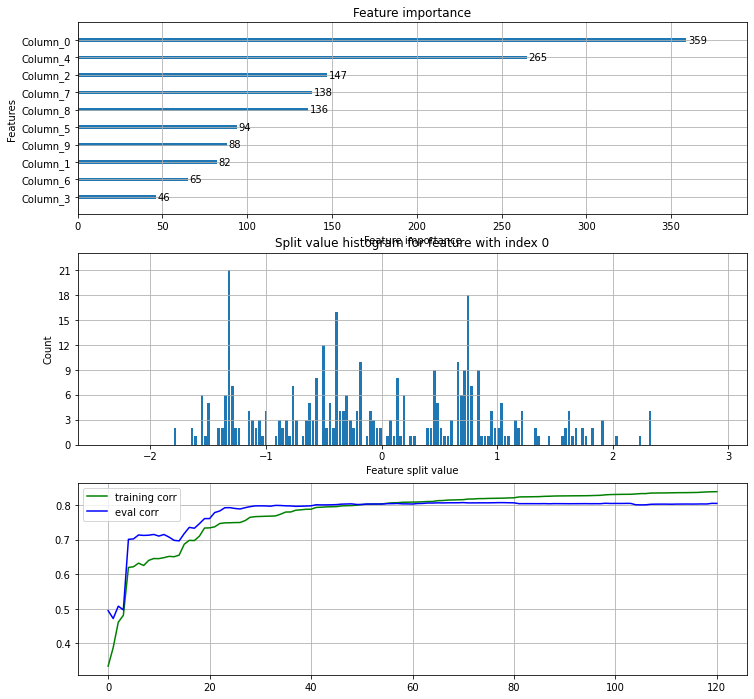

In [17]:
model = all_same_model(train_features, train_labels, 
            test_features, test_labels, 
            booster_params, 'asset0', plot=True, cv=False, cv_params=cv_params)

In [18]:
# check oj simulator's result
def get_r_hat(A, B):
    features = data_preprocess(A, B, 30, 10, scaler_file='scaler.pkl')[0]
    features = np.stack([features.iloc[-1,i::10] for i in range(10)], axis=0)
    preds = model.predict(features)
    return preds - A.values[-1]

import critic
cr = critic.Critic()
cr.submit(get_r_hat, log_pr.iloc[-1440*60:], volu.iloc[-1440*60:])

100%|██████████| 8496/8496 [05:36<00:00, 25.23it/s]

Total time used: 336.801s
Pairwise correlation:
	asset 0 = 0.00462
	asset 1 = 0.01742
	asset 2 = 0.04713
	asset 3 = 0.00238
	asset 4 = 0.01452
	asset 5 = 0.00273
	asset 6 = 0.01679
	asset 7 = 0.01391
	asset 8 = 0.01000
	asset 9 = 0.01701
	mean correlation = 0.01465
Overall correlation: -0.00873
Fail to outperform Ziwei's method, whose pairwise average
and overall correlations are (0.02840, 0.01536)


(336.8014042377472,
 0    0.004616
 1    0.017420
 2    0.047129
 3    0.002384
 4    0.014522
 5    0.002726
 6    0.016793
 7    0.013911
 8    0.009996
 9    0.017015
 dtype: float64,
 -0.008726886094218003)

In [30]:
model

LGBMRegressor(boosting='gbdt', early_stopping_round=50, feature_fraction=0.4,
              feature_fraction_bynode=0.5, feature_fraction_seed=88,
              force_row_wise=True, learning_rate=0.2, max_delta_step=0.4,
              max_depth=5, min_data_in_leaf=20, num_iterations=1000,
              num_leaves=21, objective='fair', reg_alpha=0.2, reg_lambda=0.2,
              seed=99, subsample=0.2, tree_learner='serial')

In [24]:
# model the data using SVR approximated by Nystroem and SGD regressor
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import SGDRegressor
from sklearn.multioutput import MultiOutputRegressor
feature_map_nystroem = Nystroem(gamma=.2,
                                random_state=1,
                                n_components=300)
data_transformed = feature_map_nystroem.fit_transform(train_features)
sgdreg = MultiOutputRegressor(SGDRegressor(n_iter_no_change=10, shuffle=True)).fit(data_transformed, train_labels.values)

In [25]:
# check oj simulator's result
def get_r_hat(A, B):
    features = data_preprocess(A, B, 7, 12, scaler_file='scaler.pkl')[0].values[[-1]]
    # print(features.shape)
    data_transformed = feature_map_nystroem.transform(features)
    preds = sgdreg.predict(data_transformed)
    return preds - A.values[-1]

import critic
cr = critic.Critic()
cr.submit(get_r_hat, log_pr.iloc[-1440*60:], volu.iloc[-1440*60:])

  0%|          | 0/8496 [00:00<?, ?it/s]d:\UserProjects\stats601-project\.venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but Nystroem was fitted with feature names
  warnings.warn(
d:\UserProjects\stats601-project\.venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but Nystroem was fitted with feature names
  warnings.warn(
d:\UserProjects\stats601-project\.venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but Nystroem was fitted with feature names
  warnings.warn(
d:\UserProjects\stats601-project\.venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but Nystroem was fitted with feature names
  warnings.warn(
  0%|          | 4/8496 [00:00<04:30, 31.39it/s]d:\UserProjects\stats601-project\.venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but Nystroem was fitted with fea

Total time used: 292.515s
Pairwise correlation:
	asset 0 = 0.00191
	asset 1 = 0.04660
	asset 2 = 0.04656
	asset 3 = 0.02994
	asset 4 = 0.05287
	asset 5 = 0.02211
	asset 6 = 0.03380
	asset 7 = 0.02444
	asset 8 = 0.04227
	asset 9 = 0.03333
	mean correlation = 0.03338
Overall correlation: -0.01151
Fail to outperform Ziwei's method, whose pairwise average
and overall correlations are (0.02840, 0.01536)


(292.5151810646057,
 0    0.001906
 1    0.046601
 2    0.046565
 3    0.029940
 4    0.052868
 5    0.022105
 6    0.033805
 7    0.024441
 8    0.042271
 9    0.033332
 dtype: float64,
 -0.011509514583316166)

In [20]:
# random forest
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
regr = RandomForestRegressor(max_depth=3, random_state=0, n_estimators=100)
regr.fit(train_features.values, train_labels.values)

RandomForestRegressor(max_depth=3, random_state=0)

In [21]:
# check oj simulator's result
def get_r_hat(A, B):
    features = data_preprocess(A, B, 7, 12, scaler_file='scaler.pkl')[0].values[[-1]]
    preds = regr.predict(features)
    return preds - A.values[-1]

import critic
cr = critic.Critic()
cr.submit(get_r_hat, log_pr.iloc[-1440*60:], volu.iloc[-1440*60:])

100%|██████████| 8496/8496 [04:37<00:00, 30.63it/s]

Total time used: 277.418s
Pairwise correlation:
	asset 0 = 0.00188
	asset 1 = 0.04686
	asset 2 = 0.04066
	asset 3 = 0.02996
	asset 4 = 0.05206
	asset 5 = 0.02217
	asset 6 = 0.03565
	asset 7 = 0.02286
	asset 8 = 0.04477
	asset 9 = 0.03314
	mean correlation = 0.03300
Overall correlation: -0.00410
Fail to outperform Ziwei's method, whose pairwise average
and overall correlations are (0.02840, 0.01536)


(277.41783595085144,
 0    0.001876
 1    0.046855
 2    0.040663
 3    0.029957
 4    0.052058
 5    0.022173
 6    0.035653
 7    0.022855
 8    0.044767
 9    0.033136
 dtype: float64,
 -0.00409777705851289)

In [22]:
# linear regression
from sklearn.linear_model import LinearRegression
linreg = MultiOutputRegressor(LinearRegression())
linreg.fit(train_features.values, train_labels.values)

MultiOutputRegressor(estimator=LinearRegression())

In [23]:
def get_r_hat(A, B):
    features = data_preprocess(A, B, 30, 10, scaler_file='scaler.pkl')[0]
    pred = linreg.predict(features.values[[-1]])
    return pred - A.values[-1]

import critic
cr = critic.Critic()
cr.submit(get_r_hat, log_pr.iloc[-1440*60:], volu.iloc[-1440*60:])

100%|██████████| 8496/8496 [04:09<00:00, 34.02it/s]

Total time used: 249.767s
Pairwise correlation:
	asset 0 = -0.00996
	asset 1 = 0.03372
	asset 2 = -0.03849
	asset 3 = -0.00673
	asset 4 = 0.06136
	asset 5 = 0.00559
	asset 6 = 0.02415
	asset 7 = -0.00642
	asset 8 = 0.09852
	asset 9 = 0.07333
	mean correlation = 0.02351
Overall correlation: 0.00089
Fail to outperform Ziwei's method, whose pairwise average
and overall correlations are (0.02840, 0.01536)


(249.76701998710632,
 0   -0.009962
 1    0.033723
 2   -0.038489
 3   -0.006726
 4    0.061357
 5    0.005591
 6    0.024149
 7   -0.006417
 8    0.098520
 9    0.073329
 dtype: float64,
 0.0008892811651215379)

In [28]:
# ensemble regressors
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import GradientBoostingRegressor

estimators = [('ridge', RidgeCV()),
                ('Lasso', LassoCV()),
                ('knr', KNeighborsRegressor(n_neighbors=20, metric='euclidean'))]
final_estimator = GradientBoostingRegressor(
                        n_estimators=25, subsample=0.2, 
                        min_samples_leaf=25, max_features=1)
reg = MultiOutputRegressor(StackingRegressor(estimators=estimators, final_estimator=final_estimator))
reg.fit(train_features.values, train_labels.values)


MultiOutputRegressor(estimator=StackingRegressor(estimators=[('ridge',
                                                              RidgeCV(alphas=array([ 0.1,  1. , 10. ]))),
                                                             ('Lasso',
                                                              LassoCV()),
                                                             ('knr',
                                                              KNeighborsRegressor(metric='euclidean',
                                                                                  n_neighbors=20))],
                                                 final_estimator=GradientBoostingRegressor(max_features=1,
                                                                                           min_samples_leaf=25,
                                                                                           n_estimators=25,
                                                                               

In [29]:
def get_r_hat(A, B):
    features = data_preprocess(A, B, 3, daylen, scaler_file='scaler.pkl')[0]
    pred = reg.predict(features.values[[-1]])
    return pred - A.values[-1]

import critic
cr = critic.Critic()
cr.submit(get_r_hat, log_pr.iloc[-1440*60:], volu.iloc[-1440*60:])

100%|██████████| 8496/8496 [07:19<00:00, 19.34it/s]

Total time used: 439.222s
Pairwise correlation:
	asset 0 = 0.00510
	asset 1 = 0.03996
	asset 2 = 0.03336
	asset 3 = 0.02498
	asset 4 = 0.04031
	asset 5 = 0.02135
	asset 6 = 0.03054
	asset 7 = 0.02493
	asset 8 = 0.04971
	asset 9 = 0.03107
	mean correlation = 0.03013
Overall correlation: -0.00574
Fail to outperform Ziwei's method, whose pairwise average
and overall correlations are (0.02840, 0.01536)


(439.22202491760254,
 0    0.005098
 1    0.039959
 2    0.033357
 3    0.024977
 4    0.040305
 5    0.021348
 6    0.030538
 7    0.024935
 8    0.049711
 9    0.031066
 dtype: float64,
 -0.005738016757328769)

mean correlation = 0.01246

Overall correlation: -0.00831

In [52]:
def get_r_hat(A, B):
    # print(A.shape, B.shape)
    features = data_preprocess(A, B, 3, daylen, scaler_file='scaler.pkl')[0]
    # features_lgb = np.stack([features.iloc[-1,i::10].values for i in range(10)], axis=0)
    # pred_lgb = model.predict(features_lgb)
    data_transformed = feature_map_nystroem.transform(features)
    pred_sgdreg = sgdreg.predict(data_transformed[[-1]]).squeeze()
    pred_reg = reg.predict(features.values[[-1]]).squeeze()
    # print(pred_reg.shape)
    pred_linreg = linreg.predict(features.values[[-1]]).squeeze()
    # print(pred_linreg.shape)
    preds = np.stack([pred_sgdreg, pred_reg, pred_linreg, A.values[-30], A.rolling(12).mean().values[-1]], axis=1).mean(axis=1)
    return preds - A.values[-1]

# import critic
# cr = critic.Critic()
# cr.submit(get_r_hat, log_pr.iloc[-1440*60:], volu.iloc[-1440*60:])

In [57]:
from tqdm import tqdm
import time
import datetime
from joblib import Parallel, delayed    

t0 = time.time()
dt = datetime.timedelta(days=1) - datetime.timedelta(seconds=60)
r_hat = pd.DataFrame(index=log_pr.index[-1440*60::10], columns=np.arange(10), dtype=np.float64)

for t in tqdm(log_pr.index[-1440*60::10]):
    r_hat.loc[t, :] = get_r_hat(log_pr.loc[(t - dt):t], volu.loc[(t - dt):t])

t_used = time.time() - t0
print(t_used)

# Compute true forward log_returns every 10 minutes
r_fwd = (log_pr.shift(-30) - log_pr).iloc[-1440*60::10].rename(columns={f"log_pr_{i}": i for i in range(10)})
r_fwd.corrwith(r_hat), r_fwd.corrwith(r_hat).mean()
r_fwd_all = r_fwd.iloc[:-3].values.ravel() # the final 3 rows are NaNs. 
r_hat_all = r_hat.iloc[:-3].values.ravel()
np.corrcoef(r_fwd_all, r_hat_all)[0, 1]

  1%|          | 48/8640 [00:02<08:42, 16.44it/s]


KeyboardInterrupt: 